In [1]:
%matplotlib inline 
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib
import shap
import sys; sys.path.insert(0, '..')
import numpy as np
from sklearn.model_selection import train_test_split
from Feature_selection.util import select_columns
from Server.NeuralNetwork.neuralnet import NeuralNet
shap.initjs()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#result label Encoding
{'1': 0, '2': 1, 'X': 2}


#%% md 
Dict of class value to actual string


In [2]:
class_dict={0:'Home Win',
           1:'Away Win',
           2:'Draw'}

In [3]:
X,Y=select_columns()
feature_names=list(X.columns)
class_names=['result_0','result_1','result_2']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=False)
ann=NeuralNet(x_train.shape[1])
ann.train(x_train,y_train,25)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#result label Encoding
{'1': 0, '2': 1, 'X': 2}
Batch Size:  8
Epoch 1/25
4652/4652 [==============================] - 7s 1ms/step - loss: 0.9543 - accuracy: 0.5613
Epoch 2/25
4652/4652 [==============================] - 9s 2ms/step - loss: 0.8630 - accuracy: 0.6014
Epoch 3/25
4652/4652 [==============================] - 9s 2ms/step - loss: 0.8523 - accuracy: 0.6040
Epoch 4/25
4652/4652 [==============================] - 8s 2ms/step - loss: 0.8468 - accuracy: 0.6064
Epoch 5/25
4652/4652 [==============================] - 9s 2ms/step - loss: 0.8439 - accuracy: 0.6102
Epoch 6/25
4652/4652 [==============================] - 8s 2ms/step - loss: 0.8417 - accuracy: 0.6111
Epoch 7/25
4652/4652 [==============================] - 9s 2ms/step - loss: 0.8400 - accuracy: 0.6132
Epoch 8/25
4652/4652 [==============================] - 8s 2ms/step - loss: 0.8388 - accuracy: 0.6133
Epoch 9/25
4652/4652 [==============================] - 9s 2ms/step - loss: 0.8375 - accuracy: 0.6145
Epoch 10/25
4652/46

In [4]:
# we use the first 1000 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(ann.model,x_train.sample(1000).to_numpy())

In [5]:
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd

number_of_samples=1
sample=x_test.sample(number_of_samples)

print(f'Sample:')
display(sample)
print(f'Result:')
display(y_test.loc[sample.index])
print(f'Prediction:')
display(pd.DataFrame(ann.predict(sample)))
      
to_explain=sample.to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain
feature_names=list(x_test.columns)

for which_class in range(0,3):
    print(f'Class number {which_class} : {class_dict[which_class]}')
    display(shap.force_plot(base_value=explainer.expected_value[which_class].numpy(),
                            shap_values=shap_values[which_class],
                            features=features,
                            feature_names=feature_names
                            ))


Sample:


,away_att,away_def,away_mid,away_odds_n,away_team_rank,away_team_received,away_team_scored,draw_odds_n,home_att,home_def,home_mid,home_odds_n,home_team_rank,home_team_received,home_team_scored
45741,73,70,71,0.336454,7,1.0,1.0,0.280407,74,69,69,0.383139,13,1.0,0.0


Result:


,result_0,result_1,result_2
45741,0,1,0


Prediction:


,0,1,2
0,0.213651,0.50252,0.283829


Class number 0 : Home Win


Class number 1 : Away Win


Class number 2 : Draw


Class number 0 : Home Win


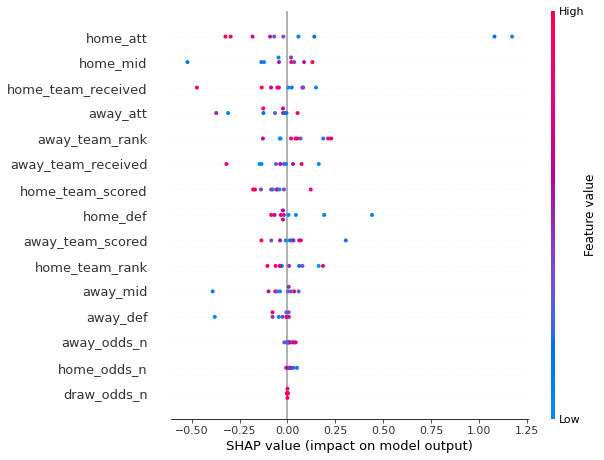

None

Class number 1 : Away Win


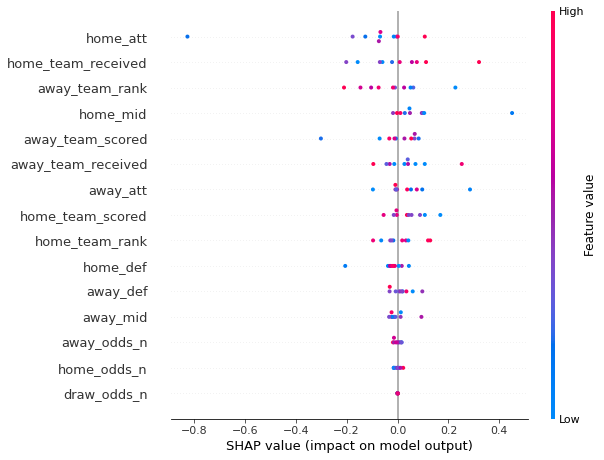

None

Class number 2 : Draw


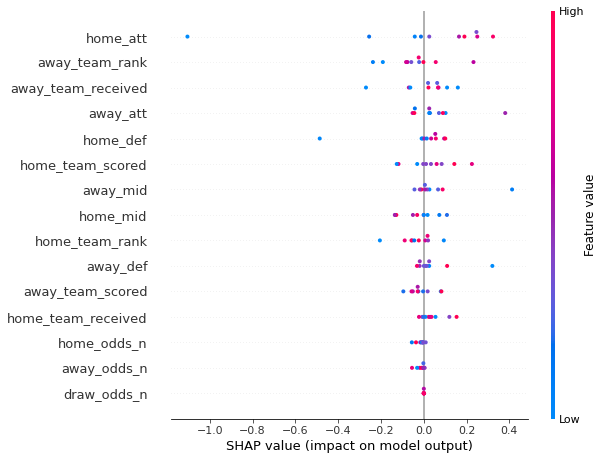

None

In [9]:
number_of_samples=10
to_explain=x_test.sample(number_of_samples).to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain

for which_class in range(0,3):
    print(f'Class number {which_class} : {class_dict[which_class]}')
    display(shap.summary_plot(
                                shap_values=shap_values[which_class],
                                features=features,
                                feature_names=feature_names
                                ))

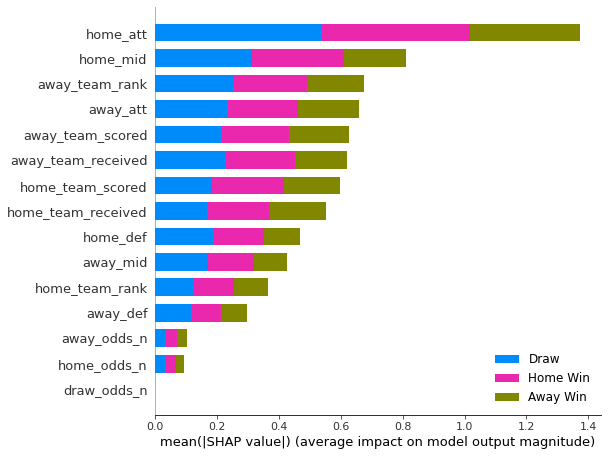

None

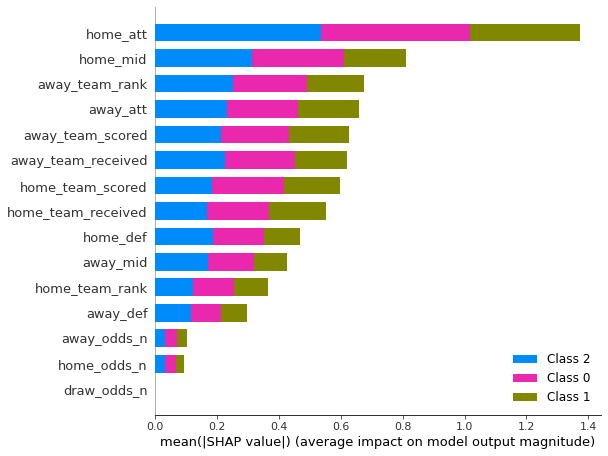

None

In [11]:
to_explain=x_test.to_numpy(copy=True)
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=x_test.to_numpy(copy=True)


display(shap.summary_plot(shap_values=shap_values,
                          features=features,
                          feature_names=feature_names,
                          class_names=class_dict))

display(shap.summary_plot(shap_values=shap_values,
                          features=features,
                          feature_names=feature_names))